In [133]:
from aostools.climate import ComputeAnnularMode
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import numpy as np
import sys
#from xrrandom import bootstrap_samples

from scipy import stats
from resampling import _resample_iterations_idx
import random

# Constants

In [2]:
root_path = '/mnt/data04/model/CMAM/0A.daily/'
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L']
its = 10000

In [3]:
plt.rcParams.update({'font.size': 22})
sns.set_style('whitegrid')

# Functions

In [4]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

random.seed(0)

def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    kde = stats.gaussian_kde(y)
    return kde(x)


def _resample(
    init, iterations, dim="member", replace=True, chunk=True, dim_max=None
):
    """Resample over ``dim`` by index ``iterations`` times.
    .. note::
        This is a much faster way to bootstrap than resampling each iteration
        individually and applying the function to it. However, this will create a
        DataArray with dimension ``iteration`` of size ``iterations``. It is probably
        best to do this out-of-memory with ``dask`` if you are doing a large number
        of iterations or using spatial output (i.e., not time series data).
    Args:
        init (xr.DataArray, xr.Dataset): Initialized prediction ensemble.
        iterations (int): Number of bootstrapping iterations.
        dim (str): Dimension name to bootstrap over. Defaults to ``'member'``.
        replace (bool): Bootstrapping with or without replacement. Defaults to ``True``.
        chunk: (bool): Auto-chunk along chunking_dims to get optimal blocksize
        dim_max (int): Number of indices from `dim` to return. Not implemented.
    Returns:
        xr.DataArray, xr.Dataset: Bootstrapped data with additional dim ```iteration```
    """
    #print(init)

        
    if dim_max is not None and dim_max <= init[dim].size:
        # select only dim_max items
        select_dim_items = dim_max
        new_dim = init[dim].isel({dim: slice(None, dim_max)})
    else:
        select_dim_items = init[dim].size
        new_dim = init[dim]
    #print(init)


    # resample with or without replacement
    if replace:
        idx = np.random.randint(0, init[dim].size, (iterations, select_dim_items))
    elif not replace:
        # create 2d np.arange()
        idx = np.linspace(
            (np.arange(init[dim].size)),
            (np.arange(init[dim].size)),
            iterations,
            dtype="int",
        )
        # shuffle each line
        for ndx in np.arange(iterations):
            np.random.shuffle(idx[ndx])
    idx_da = xr.DataArray(
        idx,
        dims=("iteration", dim),
        coords=({"iteration": range(iterations), dim: new_dim}),
    )
    transpose_kwargs = (
        {"transpose_coords": False} if isinstance(init, xr.DataArray) else {}
    )
    #print(init.transpose(dim, ..., **transpose_kwargs))
    #print(idx_da)
    return xr.apply_ufunc(
        select_bootstrap_indices_ufunc,
        init.transpose(dim, ..., **transpose_kwargs),
        idx_da.rename({'time':'sample'}),
        input_core_dims=[['time'],['iteration',]],
        vectorize=True, 
        output_core_dims=[['iteration']], 
        dask="parallelized",
        output_dtypes=[float],
    )

def select_bootstrap_indices_ufunc(x, idx):
        """Selects multi-level indices ``idx`` from xarray object ``x`` for all
        iterations."""
        # `apply_ufunc` sometimes adds a singleton dimension on the end, so we squeeze
        # it out here. This leverages multi-level indexing from numpy, so we can
        # select a different set of, e.g., ensemble members for each iteration and
        # construct one large DataArray with ``iterations`` as a dimension.
        return np.moveaxis(x.squeeze()[idx.squeeze().transpose()], 0, -1)

# Load data

In [5]:
ds = xr.open_dataset(f'{root_path}ua/ua_6hrPlev_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_anomalies_zm.nc')#.dropna('time', how='all')
#ds = ds.where(np.isfinite(ds), drop = True)
ds['plev'] = ds.plev/100.
ds['plev'].attrs['units'] = 'hPa'
ds['plev'].attrs['long_name'] = 'pressure'
ds_sel = ds.sel(lat = slice(0,None))
"""mask =  (ds.time.dt.month == 12) | \
    (ds.time.dt.month == 1) | (ds.time.dt.month == 2) #| (ds.time.dt.month == 3)

ds_sel = ds_sel.where(np.isfinite(ds_sel), drop = True)
#ds['time'] = xr.cftime_range('1979-01-01T06', '2010-12-31T18', freq='6H', calendar='noleap')
ds_sel"""
ds

<xarray.Dataset>
Dimensions:  (lat: 48, plev: 63, time: 46720)
Coordinates:
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * time     (time) datetime64[ns] 1997-01-01 ... 1990-12-31T18:00:00
    month    (time) int64 ...
Data variables:
    ua       (time, plev, lat) float64 ...

## Calculate NAM

In [6]:
am_arr = ComputeAnnularMode(ds_sel.lat.values, ds_sel.plev.values, ds_sel.ua.values, \
                            choice = 'u')
am_arr

array([[-2.06166054, -2.18784613, -2.01723641, ..., -0.92126755,
        -0.6712863 , -0.90700545],
       [-1.9998818 , -2.0759481 , -1.92192123, ..., -1.21228043,
        -0.28312713,  0.55371482],
       [-1.9639858 , -1.94832254, -1.82617355, ...,  0.85584362,
         0.60279523, -0.06047925],
       ...,
       [ 1.05518239,  1.23878908,  1.09696616, ..., -0.75150578,
        -0.43174628, -0.1803268 ],
       [ 0.73103594,  0.93021598,  0.89219679, ...,  0.88466414,
         0.92506306,  0.68428736],
       [ 0.5845161 ,  0.78314399,  0.75354949, ...,  0.99384274,
         1.22134802,  1.15251284]])

In [7]:
ds_c = ds_sel.coords.to_dataset()[['time','plev']].coords
da_am = xr.DataArray(am_arr.T, coords= ds_c)
da_am.name = 'nam'
ds_am = da_am.to_dataset()
ds_am['nam'].attrs['long_name'] = 'NAM'
ds_am

<xarray.Dataset>
Dimensions:  (plev: 63, time: 46720)
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01 ... 1990-12-31T18:00:00
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Data variables:
    nam      (plev, time) float64 -2.062 -2.0 -1.964 ... -0.1803 0.6843 1.153

# Calculation

## Composites

In [44]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 15
lag_r = range(-max_lag, max_lag+1)
timescale = 20
for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_trop = xr.open_dataset(f'{root_path}composites_woSSW_DJFonly/ptrop_absolute_comp_{name}_{timescale}days.nc')
    ds_trop['ptrop'] = ds_trop.ptrop/100.
    ds_trop = ds_trop.sel(lat = slice(50,60)).mean(['lon','lat'])
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        dates = df_dates.set_index('BeginDate')

        dates = dates.index +pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds_am.sel(time = dates)#.mean('time')
        #ds_trop_dates = ds_trop.sel(time = dates)
        
        ds_ls.append(ds_sel_dates)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = lag_r
    ds_ls2.append(xr.merge([temp,ds_trop]))
    
ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
ds_all['lag'].attrs['units'] = 'day'
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all

<xarray.Dataset>
Dimensions:  (lag: 31, plev: 63, time: 1971, what: 3)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * lag      (lag) int64 -15 -14 -13 -12 -11 -10 -9 -8 ... 8 9 10 11 12 13 14 15
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
    month    (what, lag, time) float64 1.0 nan nan nan nan ... nan nan nan nan
  * what     (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    nam      (what, lag, plev, time) float64 -0.8653 nan nan nan ... nan nan nan
    ptrop    (what, lag) float64 nan nan nan nan nan ... nan nan nan nan nan

## P-values

In [8]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 10
lag_r = range(-max_lag, max_lag+1)
timescale = 20
for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_trop = xr.open_dataset(f'{root_path}composites_woSSW_DJFonly/ptrop_absolute_comp_{name}_{timescale}days.nc')
    ds_trop['ptrop'] = ds_trop.ptrop/100.
    ds_trop = ds_trop.sel(lat = slice(50,60)).mean(['lon','lat'])
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds_am.sel(time = dates)#.mean('time')
        rnd_arr = _resample_iterations_idx(ds_am, 
                                its, 'time', replace=True, 
                                chunk=False, dim_max=ds_sel_dates.time.shape[0])
        
        da_kde = xr.apply_ufunc(g_kde, rnd_arr, ds_sel_dates.mean('time'),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)), \
                       dask_gufunc_kwargs=dict(allow_rechunk=True), \
                       output_core_dims=[[]], \
                       output_dtypes=[rnd_arr['nam'].dtype])
        
        #ds_trop_dates = ds_trop.sel(time = dates)
        #sys.exit()
        ds_ls.append(da_kde)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = lag_r
    ds_ls2.append(xr.merge([temp,ds_trop]))
    
ds_all_pv = xr.concat(ds_ls2, dim = 'what')
ds_all_pv['what'] = name_ls
ds_all_pv['lag'].attrs['units'] = 'day'
ds_all_pv['plev'].attrs['units'] = 'hPa'
ds_all_pv['plev'].attrs['long_name'] = 'pressure'
ds_all_pv['nam'].attrs['long_name'] = 'NAM'

#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all_pv

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<xarray.Dataset>
Dimensions:  (lag: 31, plev: 63, what: 3)
Coordinates:
  * lag      (lag) int64 -15 -14 -13 -12 -11 -10 -9 -8 ... 8 9 10 11 12 13 14 15
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * what     (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    nam      (what, lag, plev) float64 0.2841 0.3546 0.3555 ... 1.761 1.882 1.59
    ptrop    (what, lag) float64 nan nan nan nan nan ... nan nan nan nan nan

### FDR

In [26]:
def _ecdf(x):
    '''no frills empirical cdf used in fdrcorrection
    '''
    nobs = len(x)
    return np.arange(1,nobs+1)/float(nobs)

In [31]:
from statsmodels.stats.multitest import fdrcorrection

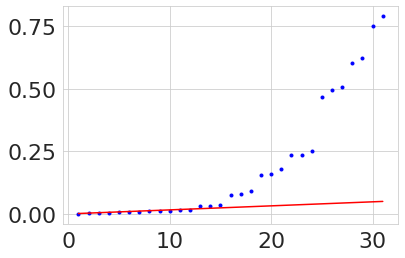

In [32]:
da = ds_all_pv['nam'].sel(plev = 10, what = 'himalayas')
N = da.shape[0]
i = np.arange(1, N+1)
q = 0.05
temp = da.sortby(da).values
plt.plot(i, temp, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')

(0.0, 0.05)

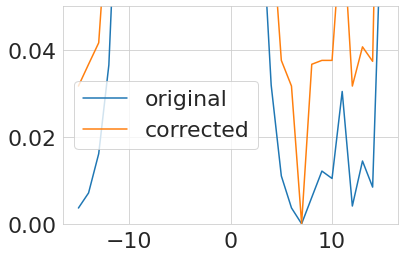

In [41]:
lags = da.lag
plt.plot(lags, da, label = 'original')
fdr = fdrcorrection(da)
plt.plot(lags, fdr[1], label='corrected')
plt.legend()
plt.ylim(0,0.05)

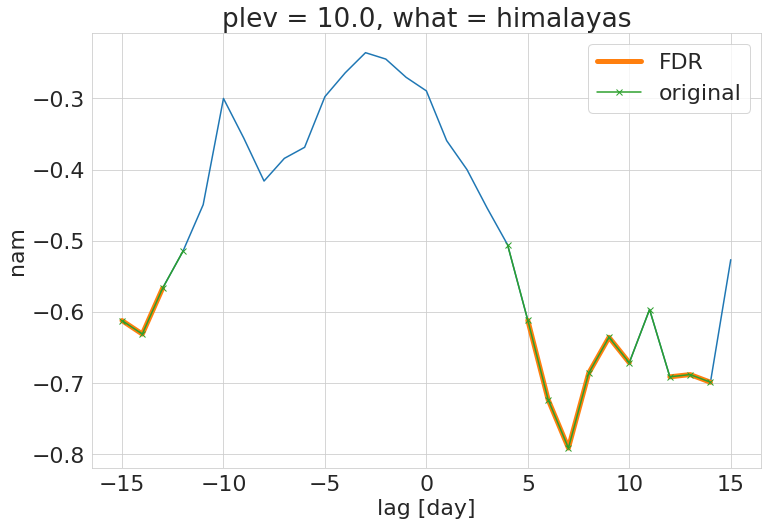

In [60]:
arr = ds_all['nam'].sel(plev = 10, what = 'himalayas').mean('time')
p = arr.plot(size = 8)
ax = p[0].axes
arr.where(fdr[0]).plot(ax = ax, label = 'FDR', lw = 5)
arr.where(da <= 0.05).plot(ax = ax, marker = 'x', label = 'original')
ax.legend()

#### 2D

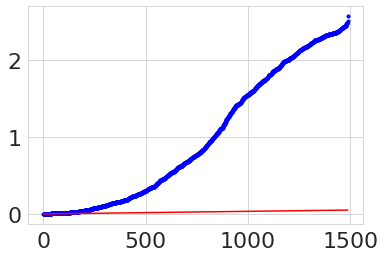

In [83]:
da = ds_all_pv['nam'].sel(
    plev = slice(None, 0.1),
    what = 'himalayas'
).stack(
    z=('lag','plev')
)
N = da.shape[0]
i = np.arange(1, N+1)
q = 0.05
temp = da.sortby(da).values
plt.plot(i, temp, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')

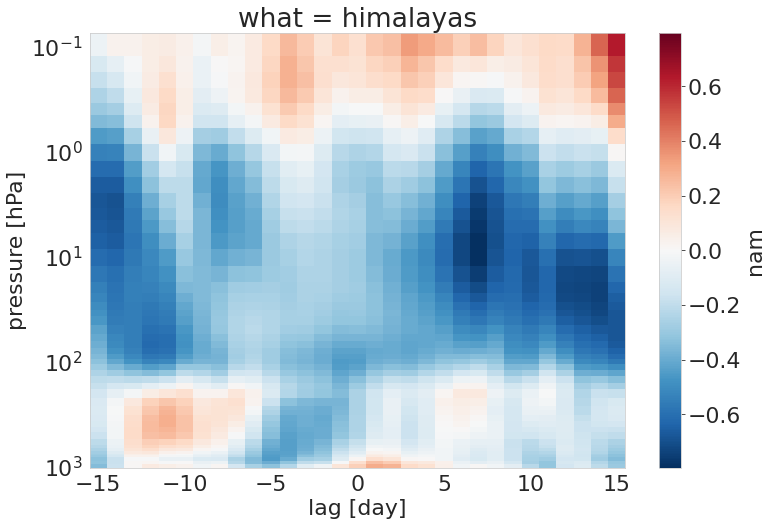

In [86]:
arr = ds_all['nam'].sel(
    what = 'himalayas',
    plev = slice(None, 0.1),
).mean('time')
p = arr.plot(x = 'lag', size = 8, yincrease = False)
ax = p.axes
#arr.where(da <= 0.05).plot(ax = ax, marker = 'x', label = 'original')
ax.set_yscale('log')
#ax.legend()

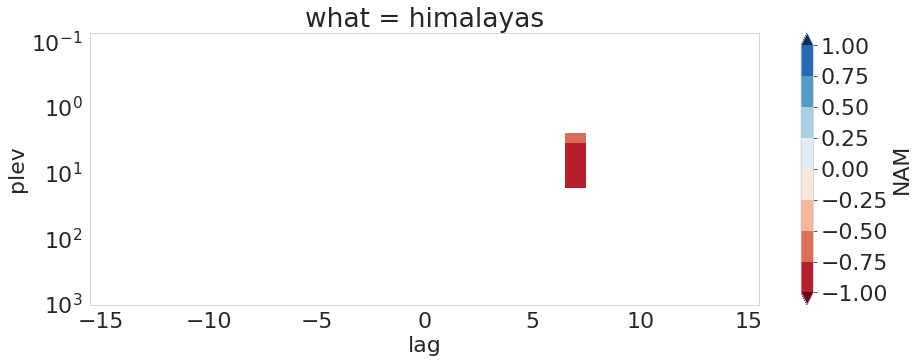

In [91]:
fdr = fdrcorrection(da)
cbar_kwargs=dict(label = 'NAM')
p = arr.stack(z=('lag','plev')).where(fdr[0]).unstack().plot(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [-1,-0.75,-.5,-0.25, 0,0.25,0.5,0.75,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)
ax = p.axes

ax.set_yscale('log')


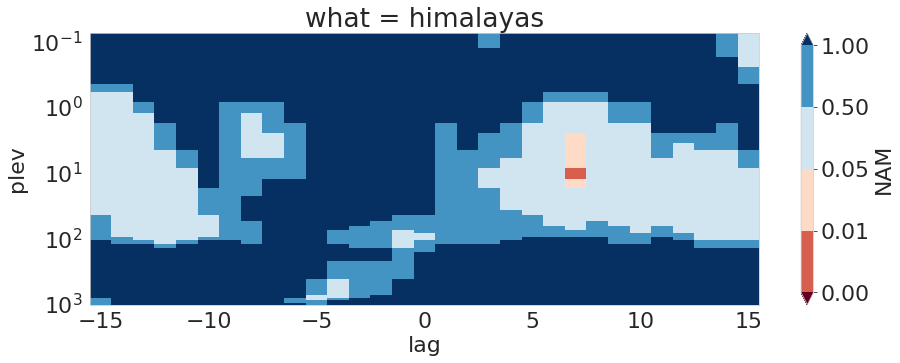

In [108]:
fdr_da = xr.DataArray(fdr[1], coords = da.coords).unstack()
p = fdr_da.plot(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [0,0.01,0.05,0.5,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)
ax = p.axes

ax.set_yscale('log')

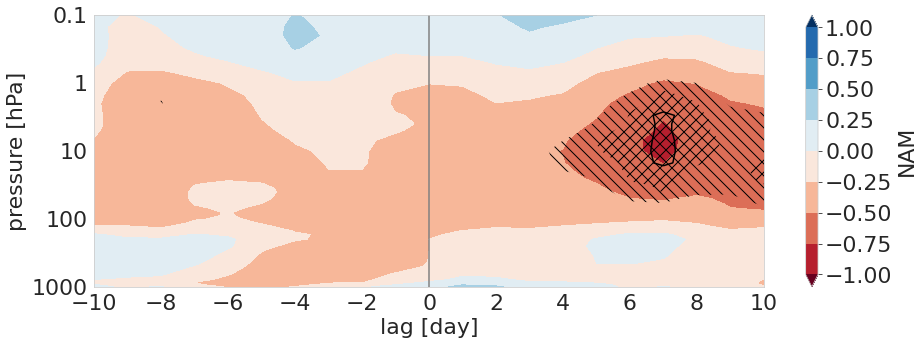

In [152]:
cbar_kwargs=dict(label = 'NAM')
p = ds_all['nam'].sel(plev = slice(None, 0.1), \
               what = 'himalayas').mean('time').plot.contourf(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [-1,-0.75,-.5,-0.25, 0,0.25,0.5,0.75,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)



ax = p.axes

plot_kwargs = dict(levels = [0,0.05], hatches=['o',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
plot_kwargs = dict(levels = [0,0.05], \
                                colors='k', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
fdr_da.sel(plev = slice(None, 0.1)).plot.contour(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['O',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
plot_kwargs = dict(levels = [0,0.01], \
                                colors='b',add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
#dr_da.sel(plev = slice(None, 0.1)).plot.contour(**plot_kwargs)

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(plev = slice(None, 0.1), 
                      what = 'himalayas').plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(plev = slice(None, 0.1), 
                      what = 'himalayas').plot.contourf(**plot_kwargs)

ax.set_yscale('log')
ax.axvline(x=0, c='gray')
ax.set_title('')
fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)       
ax.set_xlim(-10,10)
ax.set_xticks(np.arange(-10,12,2))
plt.savefig(f'NAM_lagA_composite_HIonly_FDR.pdf', bbox_inches='tight')

##### positive lags only

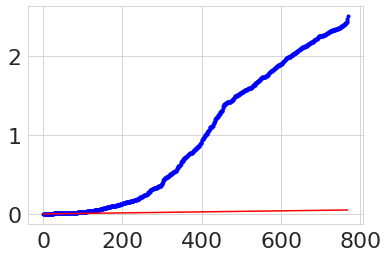

In [119]:
sel_dict = dict(
    plev = slice(None, 0.1),
    lag = slice(0,None),
    what = 'himalayas'
)
da = ds_all_pv['nam'].sel(
    **sel_dict
).stack(
    z=('lag','plev')
)
N = da.shape[0]
i = np.arange(1, N+1)
q = 0.05
temp = da.sortby(da).values
plt.plot(i, temp, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')

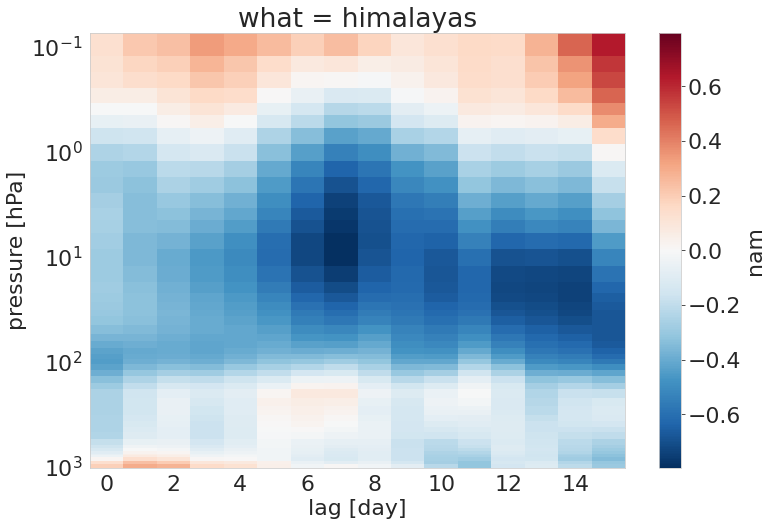

In [120]:
arr = ds_all['nam'].sel(
    **sel_dict
).mean('time')
p = arr.plot(x = 'lag', size = 8, yincrease = False)
ax = p.axes
#arr.where(da <= 0.05).plot(ax = ax, marker = 'x', label = 'original')
ax.set_yscale('log')
#ax.legend()

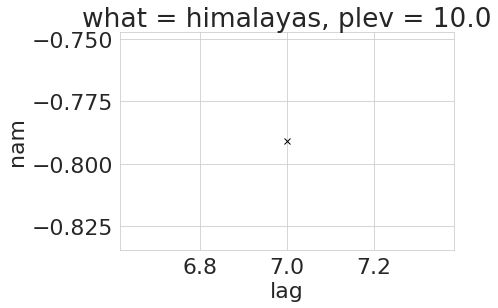

In [127]:
arr.stack(z=('lag','plev')).where(fdr[0]).unstack().sel(plev = 10).plot(color = 'k', marker = 'x')

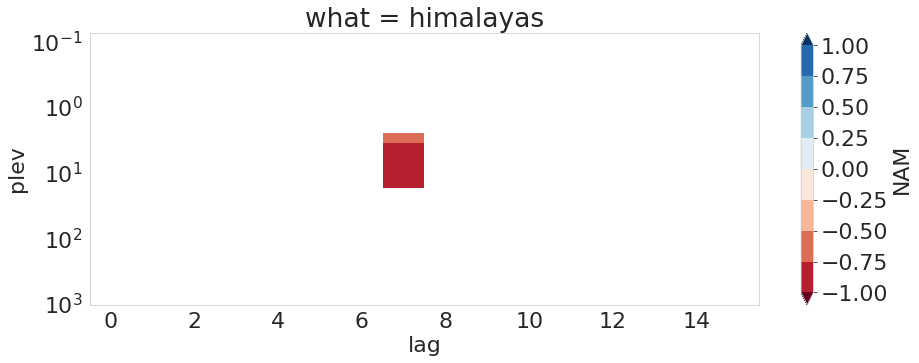

In [121]:
fdr = fdrcorrection(da)
cbar_kwargs=dict(label = 'NAM')
p = arr.stack(z=('lag','plev')).where(fdr[0]).unstack().plot(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [-1,-0.75,-.5,-0.25, 0,0.25,0.5,0.75,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)
ax = p.axes

ax.set_yscale('log')


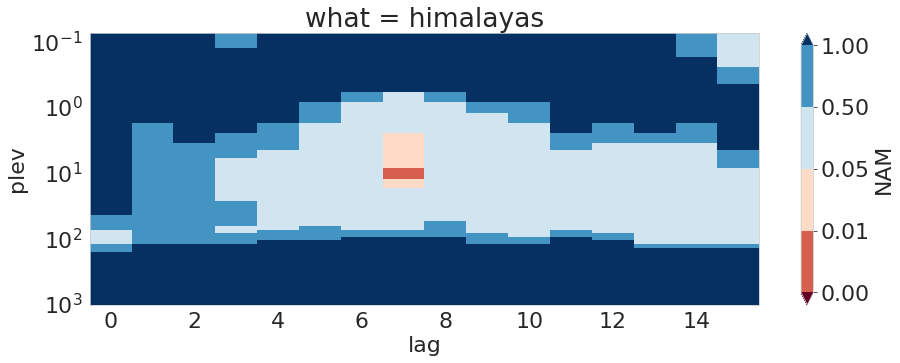

In [130]:
fdr_da = xr.DataArray(fdr[1], coords = da.coords).unstack()
p = fdr_da.plot(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [0,0.01,0.05,0.5,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)
ax = p.axes

ax.set_yscale('log')

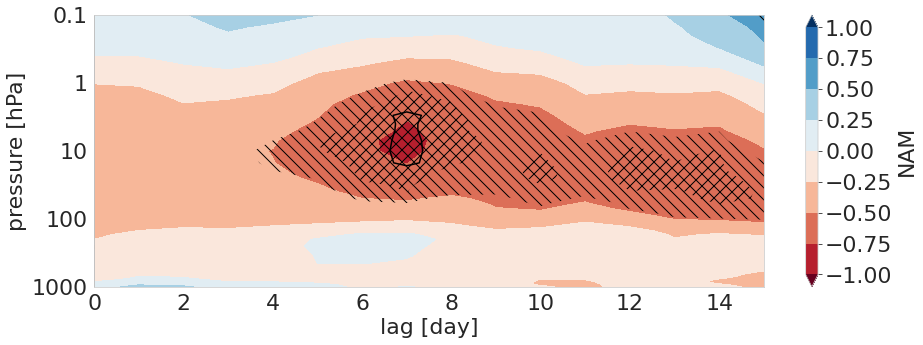

In [131]:
cbar_kwargs=dict(label = 'NAM')
p = ds_all['nam'].sel(**sel_dict).mean('time').plot.contourf(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [-1,-0.75,-.5,-0.25, 0,0.25,0.5,0.75,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)



ax = p.axes

plot_kwargs = dict(levels = [0,0.05], hatches=['o',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
plot_kwargs = dict(levels = [0,0.05], \
                                colors='k', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
fdr_da.sel(plev = slice(None, 0.1)).plot.contour(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['O',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
plot_kwargs = dict(levels = [0,0.01], \
                                colors='b',add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
#dr_da.sel(plev = slice(None, 0.1)).plot.contour(**plot_kwargs)

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(**sel_dict).plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(**sel_dict).plot.contourf(**plot_kwargs)

ax.set_yscale('log')
ax.axvline(x=0, c='gray')
ax.set_title('')
fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)       
#plt.savefig(f'NAM_lagA_composite_HIonly.pdf', bbox_inches='tight')

## Jackknife

In [230]:
name_ls = ['himalayas']#,'eastasia','westamer']
ds_ls2 = []
max_lag = 15
lag_r = range(-max_lag, max_lag+1)
timescale = 20
for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_trop = xr.open_dataset(f'{root_path}composites_woSSW_DJFonly/ptrop_absolute_comp_{name}_{timescale}days.nc')
    ds_trop['ptrop'] = ds_trop.ptrop/100.
    ds_trop = ds_trop.sel(lat = slice(50,60)).mean(['lon','lat'])
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds_am.sel(time = dates)#.mean('time')
       
        drop_ls = []
        for di in ds_sel_dates.time:
            drop_ls.append(ds_sel_dates.drop_sel(time = di.values).mean('time'))
            
                 

        ds_ls.append(xr.concat(drop_ls, dim = 'its').std('its'))
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = lag_r
    ds_ls2.append(temp)
    
ds_all_j = xr.concat(ds_ls2, dim = 'what')
ds_all_j['what'] = name_ls
ds_all_j['lag'].attrs['units'] = 'day'
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all_j

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<xarray.Dataset>
Dimensions:  (lag: 31, plev: 63, what: 1)
Coordinates:
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lag      (lag) int64 -15 -14 -13 -12 -11 -10 -9 -8 ... 8 9 10 11 12 13 14 15
  * what     (what) <U9 'himalayas'
Data variables:
    nam      (what, lag, plev) float64 0.02951 0.03143 ... 0.04161 0.04203

## Bootstrap

In [140]:
name_ls = ['himalayas']#,'eastasia','westamer']
ds_ls2 = []
max_lag = 15
lag_r = range(-max_lag, max_lag+1)
timescale = 20
for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_trop = xr.open_dataset(f'{root_path}composites_woSSW_DJFonly/ptrop_absolute_comp_{name}_{timescale}days.nc')
    ds_trop['ptrop'] = ds_trop.ptrop/100.
    ds_trop = ds_trop.sel(lat = slice(50,60)).mean(['lon','lat'])
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds_am.sel(time = dates)#.mean('time')
        rnd_arr = _resample(ds_am, 
                                its, 'time', replace=True, 
                                chunk=False, dim_max=ds_sel_dates.time.shape[0])
        

        ds_ls.append(rnd_arr)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = lag_r
    ds_ls2.append(temp)
    
ds_all_r = xr.concat(ds_ls2, dim = 'what')
ds_all_r['what'] = name_ls
ds_all_r['lag'].attrs['units'] = 'day'
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all_r

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<xarray.Dataset>
Dimensions:    (iteration: 10000, lag: 31, plev: 63, sample: 39, what: 1)
Coordinates:
  * sample     (sample) datetime64[ns] 1997-01-01 ... 1997-01-10T12:00:00
  * plev       (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * iteration  (iteration) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * lag        (lag) int64 -15 -14 -13 -12 -11 -10 -9 -8 ... 9 10 11 12 13 14 15
  * what       (what) <U9 'himalayas'
Data variables:
    nam        (what, lag, plev, sample, iteration) float64 0.4538 ... nan

# Visualisation

## Composites

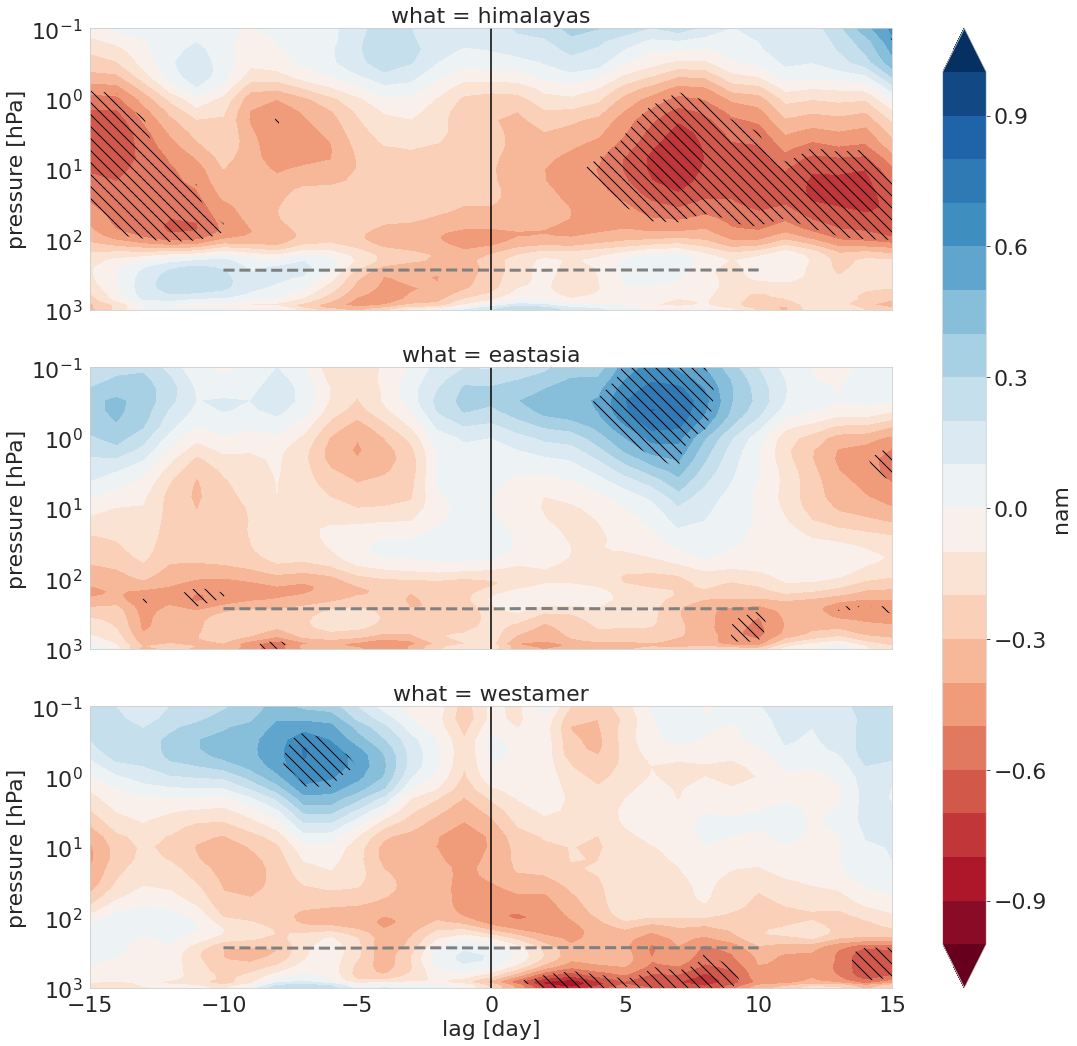

In [222]:
p = ds_all['nam'].sel(plev = slice(None, 0.1)).mean('time').plot.contourf(row = 'what', x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     vmax = 1, extend = 'both', \
                     levels = 21, size = 5, aspect = 3)
p.data = ds_all_pv['nam'].sel(plev = slice(None, 0.1))
plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False)
p.map_dataarray(xr.plot.contourf, 'lag', 'plev', **plot_kwargs)

for i,(ax, sel_dict, label) in enumerate(zip(p.axes.flat, p.name_dicts.flat, label_ls)):    
    ax.set_yscale('log')
    ax.axvline(x=0, c='k')
    
    ax.plot(lag_r, ds_all['ptrop'].sel(what = sel_dict['what'], \
                                       lag =  lag_r), ls = '--', lw = 3, color = 'gray')

### Himalayas only

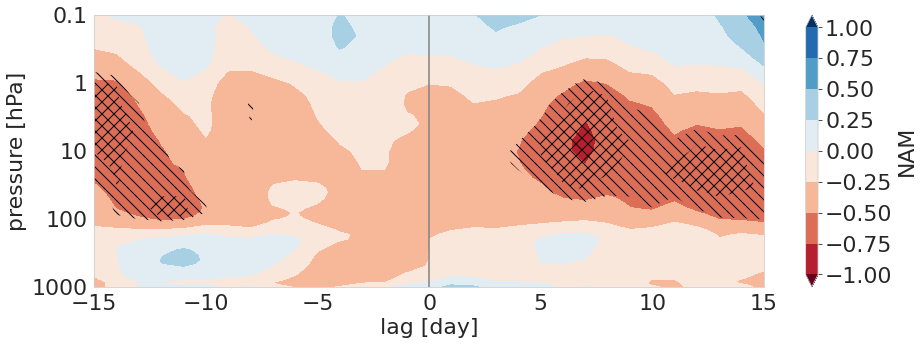

In [242]:
cbar_kwargs=dict(label = 'NAM')
p = ds_all['nam'].sel(plev = slice(None, 0.1), \
               what = 'himalayas').mean('time').plot.contourf(x = 'lag', \
                     yincrease = False, cmap = 'RdBu', \
                     extend = 'both', \
                     levels = [-1,-0.75,-.5,-0.25, 0,0.25,0.5,0.75,1], \
                     size = 5, aspect = 3, 
                     cbar_kwargs = cbar_kwargs)



ax = p.axes

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(plev = slice(None, 0.1), 
                      what = 'himalayas').plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                colors='none', add_colorbar=False,
                    yincrease = False, x = 'lag', ax=ax, y = 'plev')
ds_all_pv['nam'].sel(plev = slice(None, 0.1), 
                      what = 'himalayas').plot.contourf(**plot_kwargs)

ax.set_yscale('log')
ax.axvline(x=0, c='gray')
ax.set_title('')
fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)       
"""
ax.plot(lag_r, ds_all['ptrop'].sel(what ='himalayas', \
                                       lag =  lag_r), ls = '--', lw = 3, color = 'gray')
"""
plt.savefig(f'NAM_lagA_composite_HIonly.pdf', bbox_inches='tight')

In [143]:
sel_var = 'nam'
df_all = ds_all.to_array().sel(plev = [1000,100,50,10], 
                               variable = sel_var).to_dataframe(name = sel_var).reset_index().drop(columns=['time','variable'])#)
df_all.head()

,what,lag,plev,month,nam
0,himalayas,-15,1000.0,1.0,-0.865307
1,himalayas,-15,1000.0,NaN,NaN
2,himalayas,-15,1000.0,NaN,NaN
3,himalayas,-15,1000.0,NaN,NaN
4,himalayas,-15,1000.0,NaN,NaN


In [15]:
sel_lag = 7
month_mask =  (ds_am.time.dt.month == 12) | \
    (ds_am.time.dt.month == 1) | (ds_am.time.dt.month == 2) #| (ds.time.dt.month == 3)

df_clim = ds_am.sel(time = month_mask, plev = [1000,100,50,10]).to_array().to_dataframe(name = sel_var).reset_index().drop(columns=['time','variable'])
df_clim['what'] = ['clim']*df_clim.shape[0]
df_clim['lag'] = [sel_lag]*df_clim.shape[0]
#df_clim['lag'] = [0]*df_clim.shape[0]
df_merged = pd.concat([df_clim, df_all])
df_merged.head()

,plev,month,nam,what,lag
0,1000.0,1.0,-2.061661,clim,7
1,1000.0,1.0,-1.999882,clim,7
2,1000.0,1.0,-1.963986,clim,7
3,1000.0,1.0,-1.867114,clim,7
4,1000.0,1.0,-1.852142,clim,7


Text(0.5, 43.75999999999992, 'lag [day]')

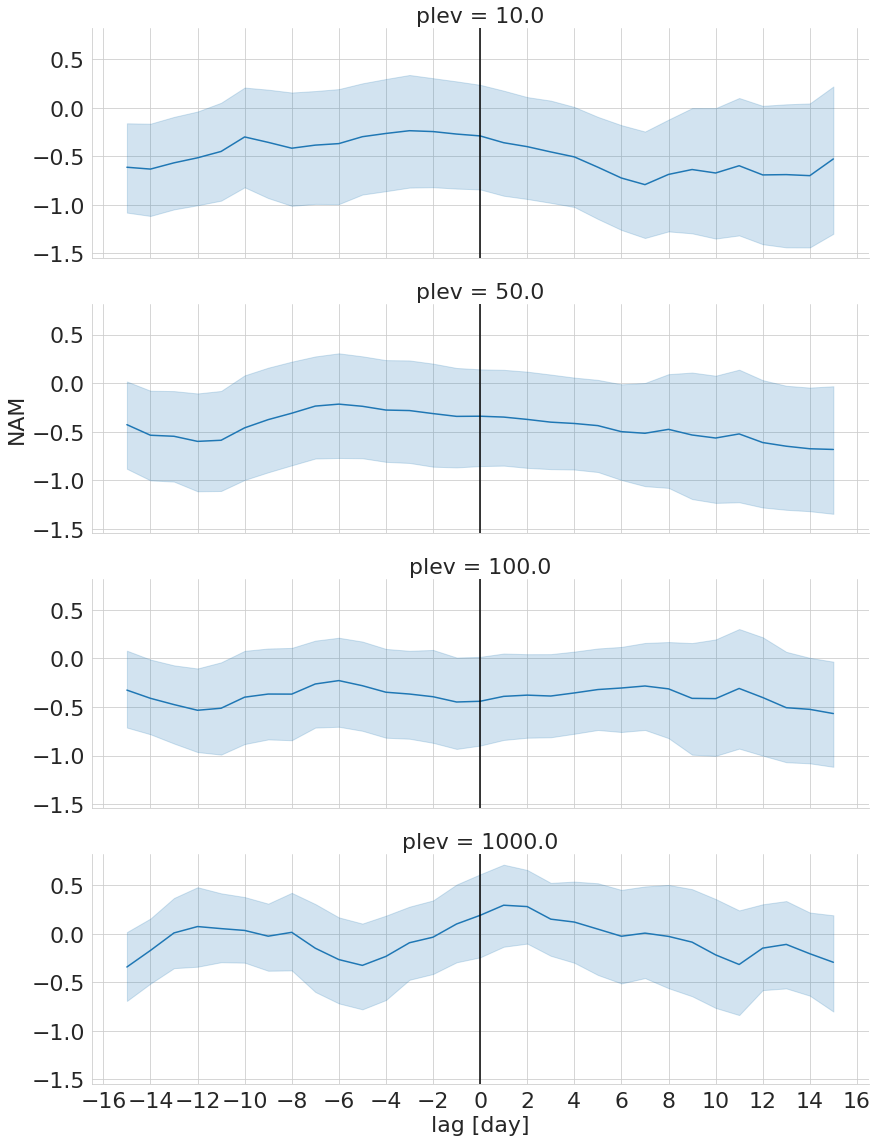

In [17]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['what'] == sel_what) 
data = df_all[mask]#.drop(columns = '')

g = sns.FacetGrid(data, row = 'plev', sharey=True,  height = 4, aspect = 3)#, margin_titles = True)
g.map(sns.lineplot, "lag", sel_var, n_boot=10000)
g.map(plt.axvline, x=0, c='k')
#g.map(plt.axhline, y=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[1][0].set_ylabel('NAM')
g.axes[-1][0].set_xlabel('lag [day]')

## Distribution plots

<AxesSubplot:xlabel='nam', ylabel='Density'>

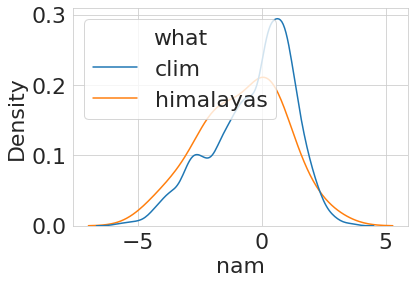

In [18]:
mask = df_merged['what'].isin([sel_what,'clim']) & \
(df_merged['plev'] == 10) & (df_merged['lag'] == 7)
data = df_merged[mask]
sns.kdeplot(data=data, x = 'nam', hue = 'what', common_norm = False)

Text(0.5, 0, 'NAM')

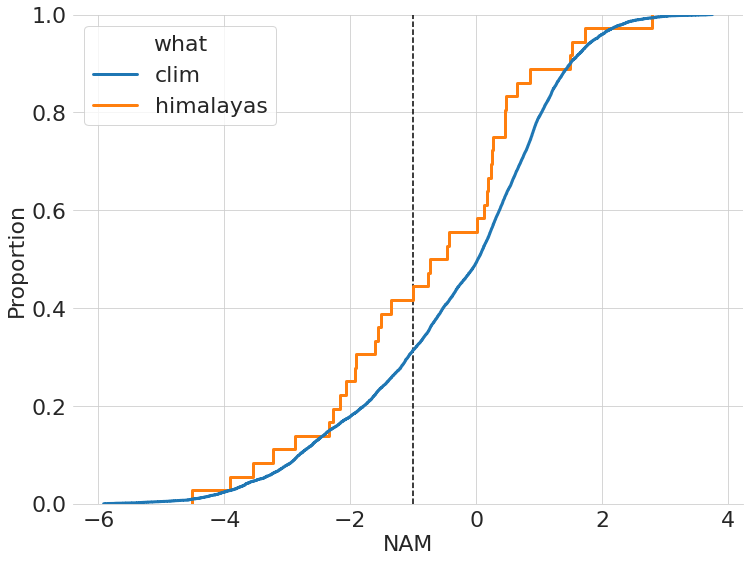

In [183]:
fig = plt.figure(figsize=(12,9)) # palette="crest",
p = sns.ecdfplot(
    data=data, x="nam", hue="what", lw = 3,
)
sns.despine(left=True)
plt.vlines(-1,0,1, linestyles='dashed', color = 'k')
plt.xlabel('NAM')

Text(0.5, 0, 'NAM')

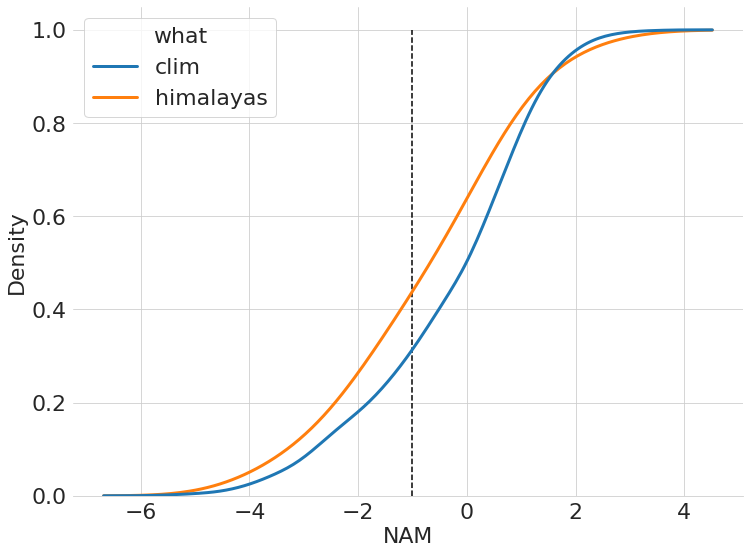

In [19]:
fig = plt.figure(figsize=(12,9)) # palette="crest",
p = sns.kdeplot(
    data=data, x="nam", hue="what", lw = 3,
    cumulative=True, common_norm=False, common_grid=True,
)
sns.despine(left=True)
plt.vlines(-1,0,1, linestyles='dashed', color = 'k')
plt.xlabel('NAM')

## Probability

In [27]:
x_ls = []
prob_ls = []
thres = -1
for i, name in zip(range(2), [sel_what, 'clim']):
    x,y=p.get_lines()[i].get_data()    
    prob = y[x<=thres][-1]                   
    prob_ls.append(y)
    x_ls.append(x)
    
    print(name, thres, prob)

himalayas -1 0.42884680612191417
clim -1 0.30531763034083703


/tmp/ipykernel_2879052/1240828543.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, prob_ls[0]/prob_ls[1], lw = 3)


Text(0, 0.5, 'P ratio with respect to climatology')

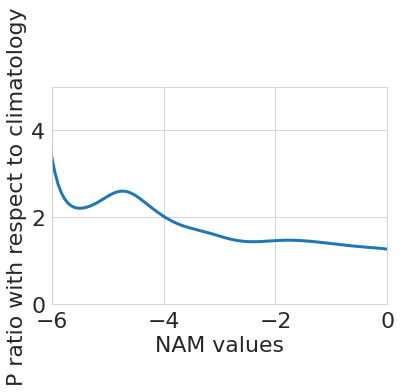

In [28]:
plt.plot(x, prob_ls[0]/prob_ls[1], lw = 3)
plt.xlim(-6,0)
plt.ylim(0,5)
plt.xlabel('NAM values')
plt.ylabel('P ratio with respect to climatology')

In [131]:
for thres in [-2,-1]:
    for i, name in zip(range(2), [sel_what, 'clim']):
        x,y=p.get_lines()[i].get_data()    
        prob = y[x<=thres][-1]                   
        print(name, thres, prob)

himalayas -2 0.2624464771904507
clim -2 0.17930903917783347
himalayas -1 0.42884680612191417
clim -1 0.30531763034083703


In [184]:
for thres in [-2,-1]:
    for i, name in zip(range(2), [sel_what, 'clim']):
        x,y=p.get_lines()[i].get_data()    
        prob = y[x<=thres][-1]                   
        print(name, thres, prob)

himalayas -2 0.25
clim -2 0.17838541666666666
himalayas -1 0.4444444444444444
clim -1 0.3140625


In [134]:
lag_r

range(-15, 16)

-15 -1 himalayas 0.37943138131449405
-15 -1 clim 0.3053173178699302
-14 -1 himalayas 0.3814000773322049
-14 -1 clim 0.305317348134893
-13 -1 himalayas 0.3517623911332098
-13 -1 clim 0.3053173530326261
-12 -1 himalayas 0.35630964773838536
-12 -1 clim 0.3053173658783309
-11 -1 himalayas 0.36365637583755767
-11 -1 clim 0.30531741675319407
-10 -1 himalayas 0.331212614832245
-10 -1 clim 0.3053174726017328
-9 -1 himalayas 0.3273408515200414
-9 -1 clim 0.3053175745319068
-8 -1 himalayas 0.3273884975710003
-8 -1 clim 0.3053177119912677
-7 -1 himalayas 0.3039874229334338
-7 -1 clim 0.3053177137375349
-6 -1 himalayas 0.3013367066640377
-6 -1 clim 0.30531772787693773
-5 -1 himalayas 0.2882440416215725
-5 -1 clim 0.3053177237195278
-4 -1 himalayas 0.29375619022611205
-4 -1 clim 0.3053177739382644
-3 -1 himalayas 0.2915848024692021
-3 -1 clim 0.3053177522631152
-2 -1 himalayas 0.2959510430388059
-2 -1 clim 0.3053177039692974
-1 -1 himalayas 0.29236525090912846
-1 -1 clim 0.3053176020848508
0 -1 him

/tmp/ipykernel_1729459/1415235424.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,9)) # palette="crest",


5 -1 himalayas 0.39151908727576695
5 -1 clim 0.3053174843627205
6 -1 himalayas 0.41447428347648113
6 -1 clim 0.3053175602345543
7 -1 himalayas 0.42884680612191417
7 -1 clim 0.30531763034083703
8 -1 himalayas 0.4100818177211282
8 -1 clim 0.3053176632989036
9 -1 himalayas 0.4117183148977444
9 -1 clim 0.30531778584904834
10 -1 himalayas 0.43314323873920063
10 -1 clim 0.3053178642972337
11 -1 himalayas 0.43387425527530565
11 -1 clim 0.3053180013495307
12 -1 himalayas 0.44733666468102784
12 -1 clim 0.3053179772347733
13 -1 himalayas 0.43270225729867823
13 -1 clim 0.3053180028950592
14 -1 himalayas 0.4243418049586894
14 -1 clim 0.30531800795605285
15 -1 himalayas 0.37771005303025673
15 -1 clim 0.30531795234145764


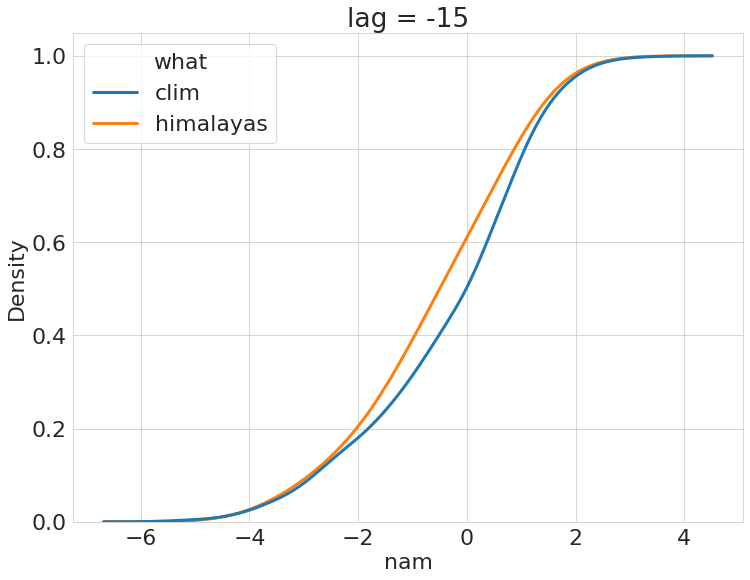

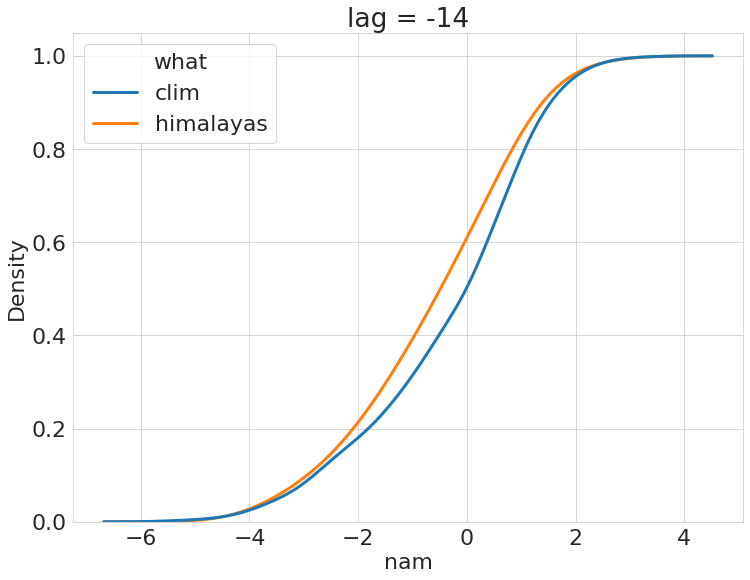

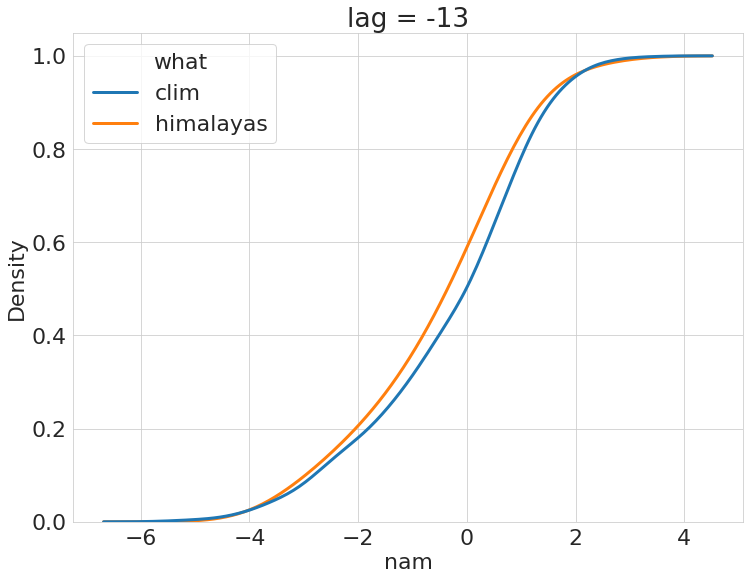

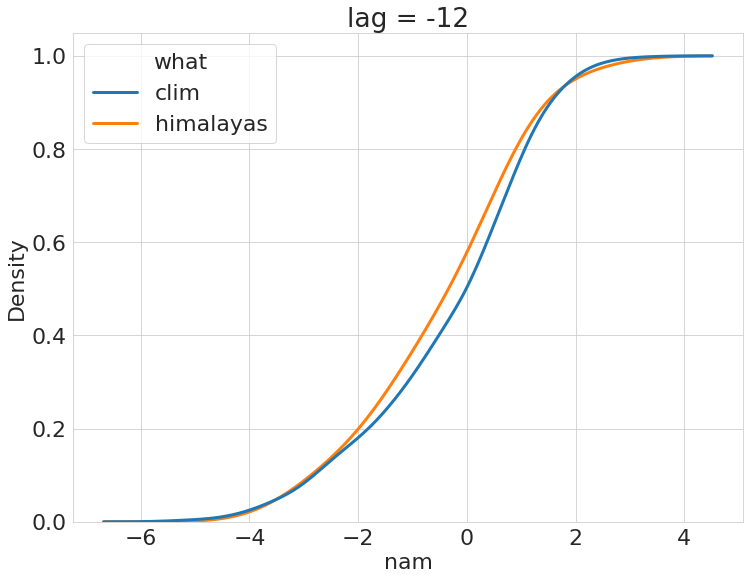

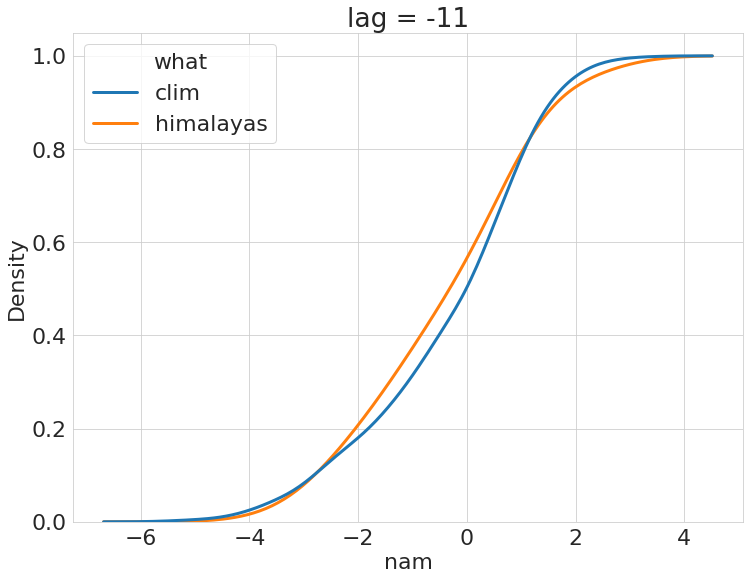

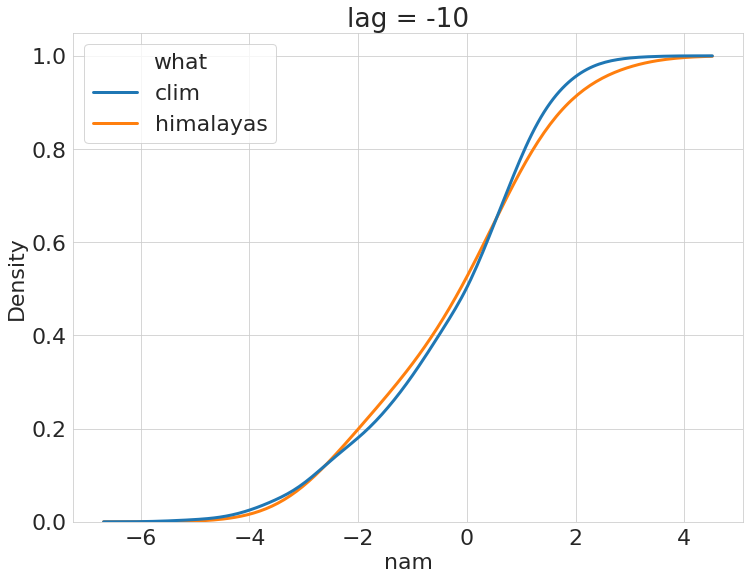

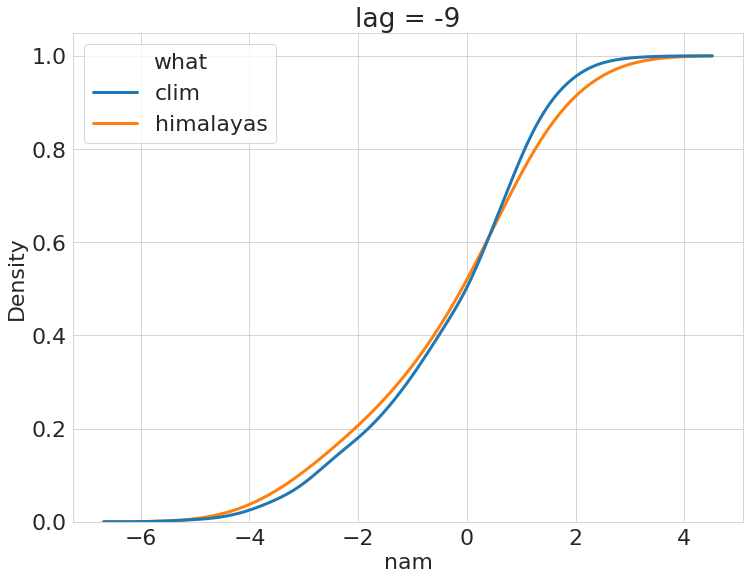

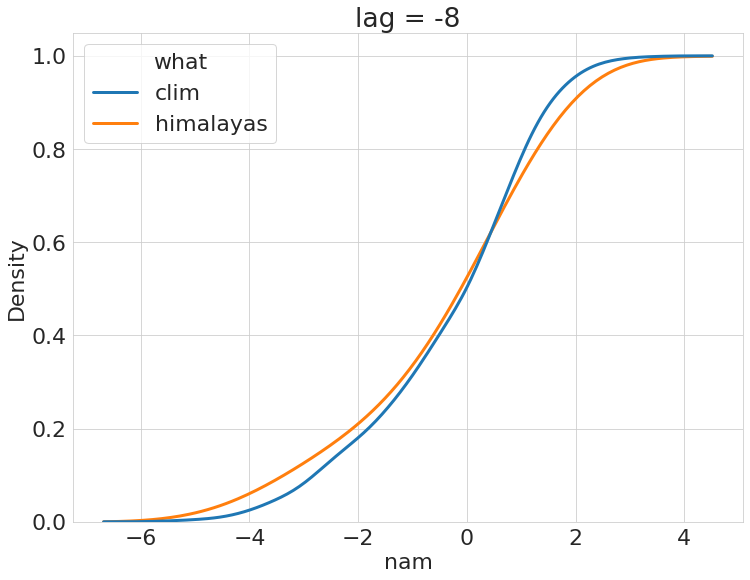

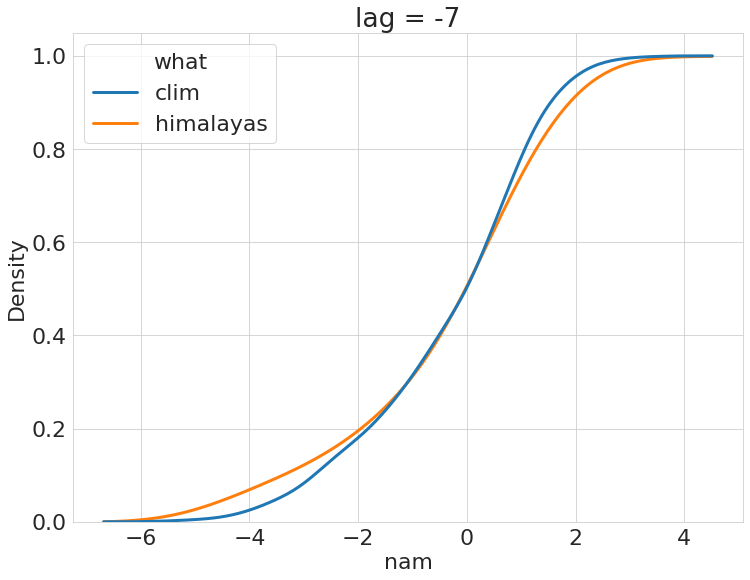

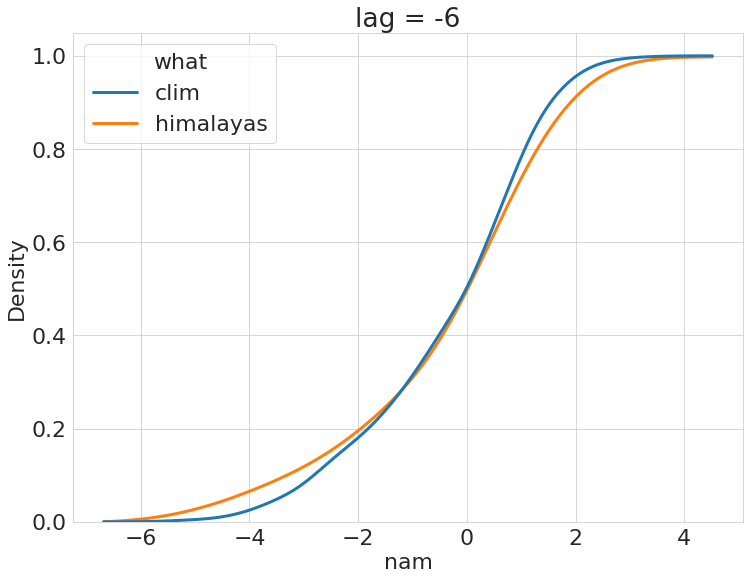

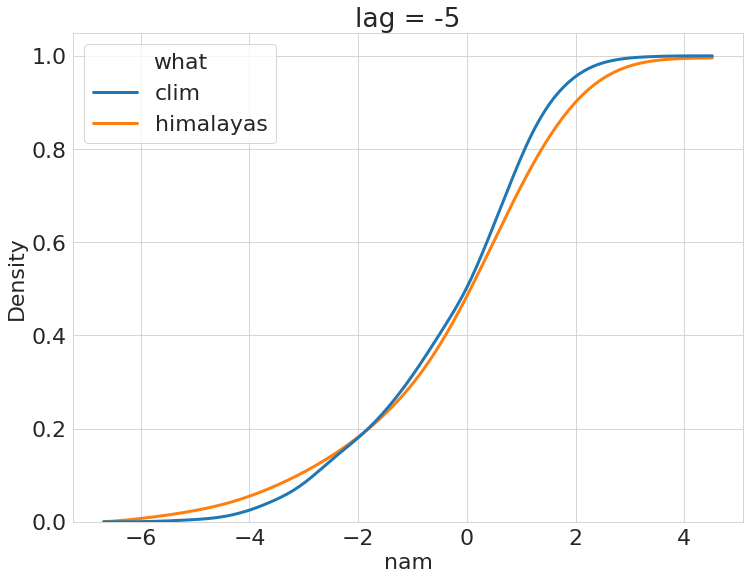

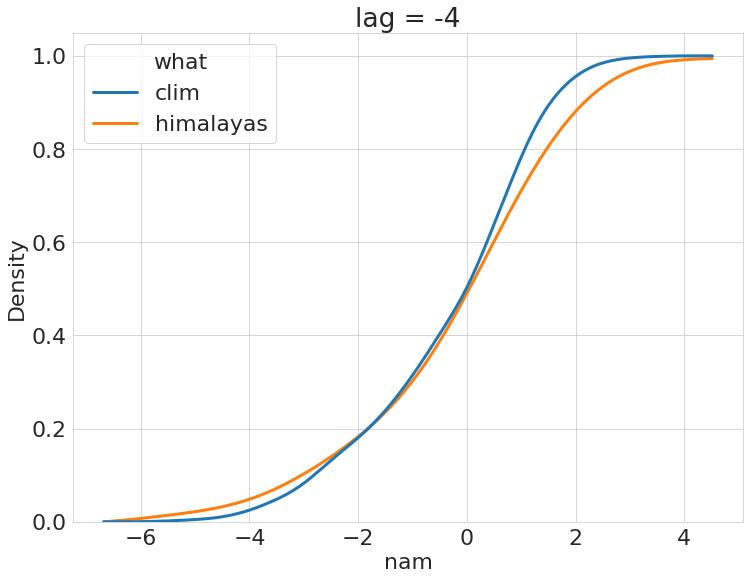

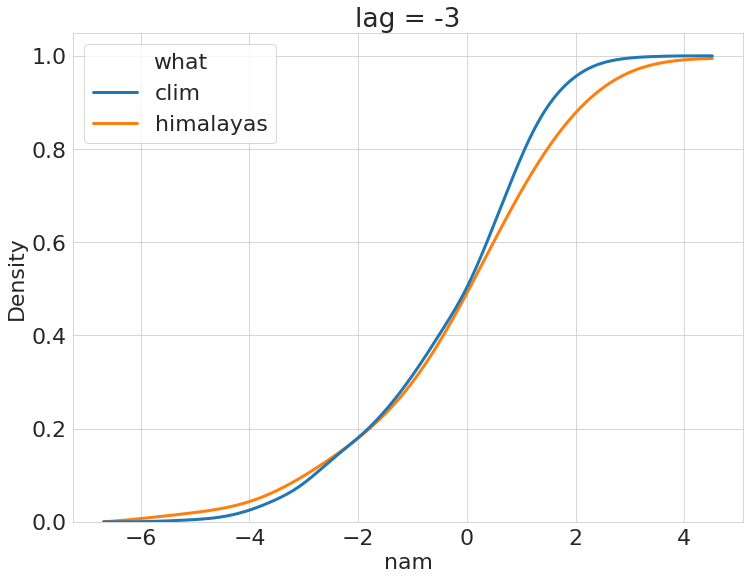

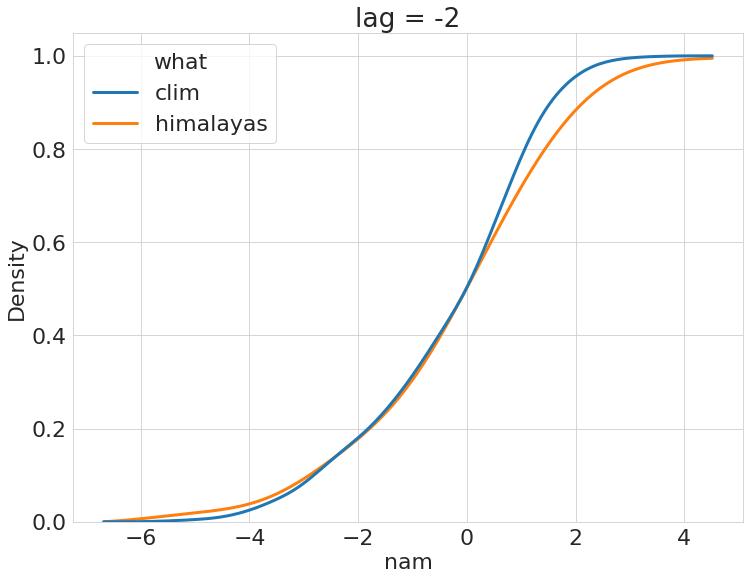

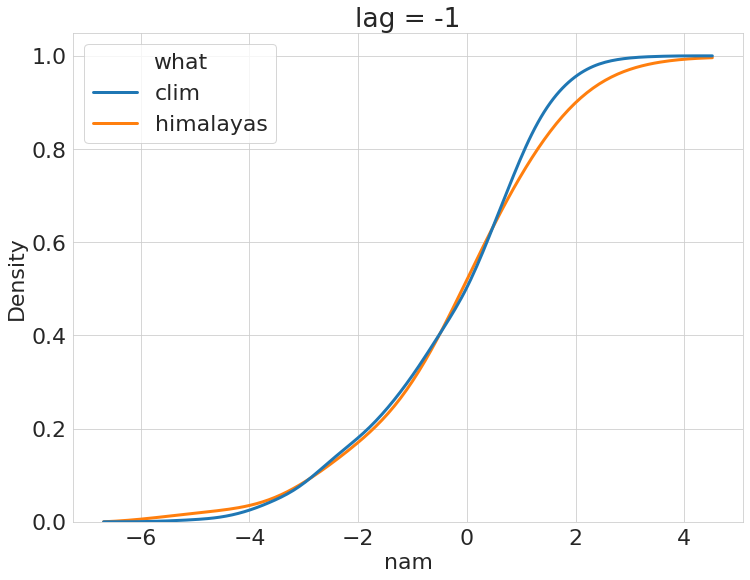

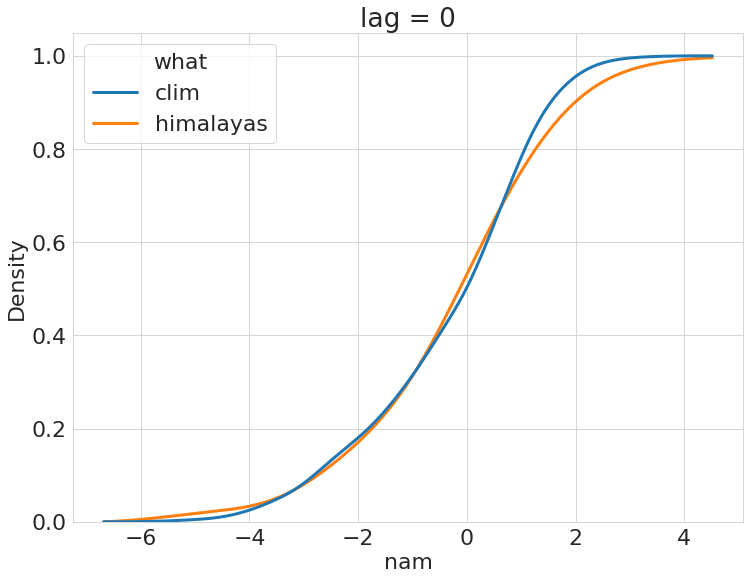

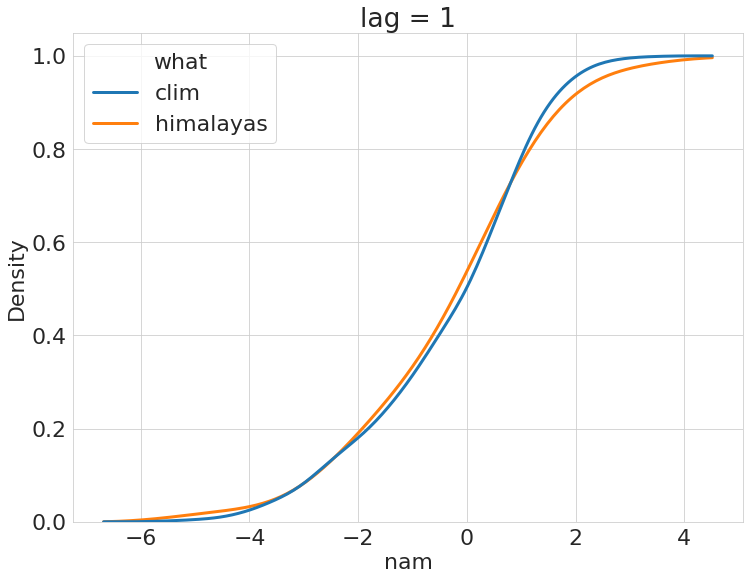

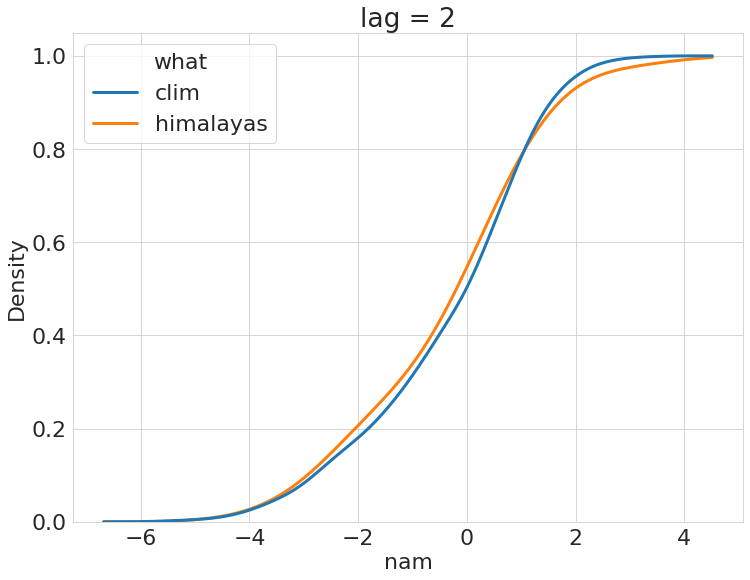

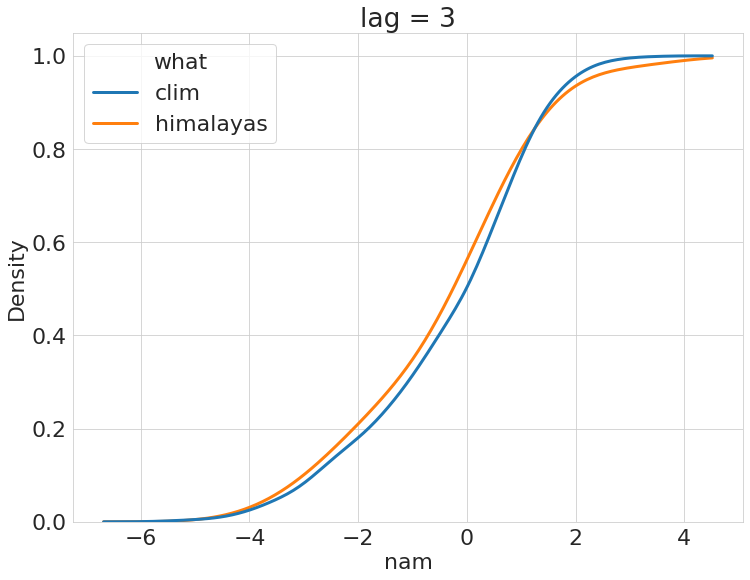

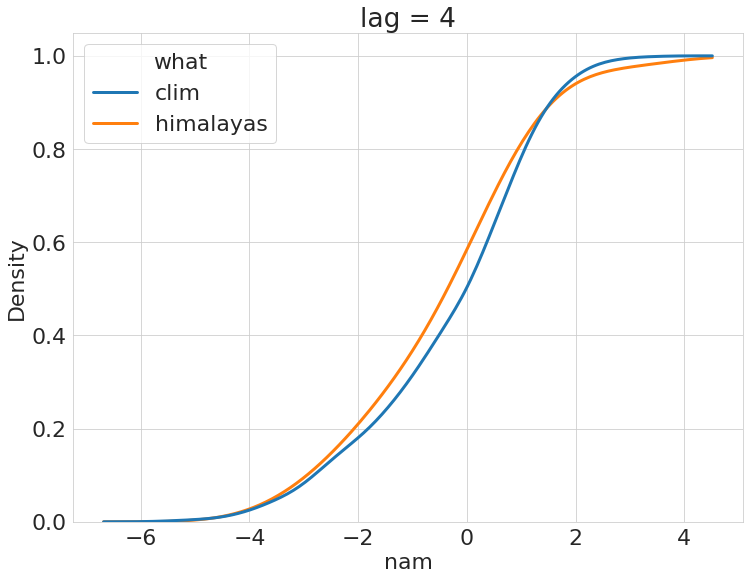

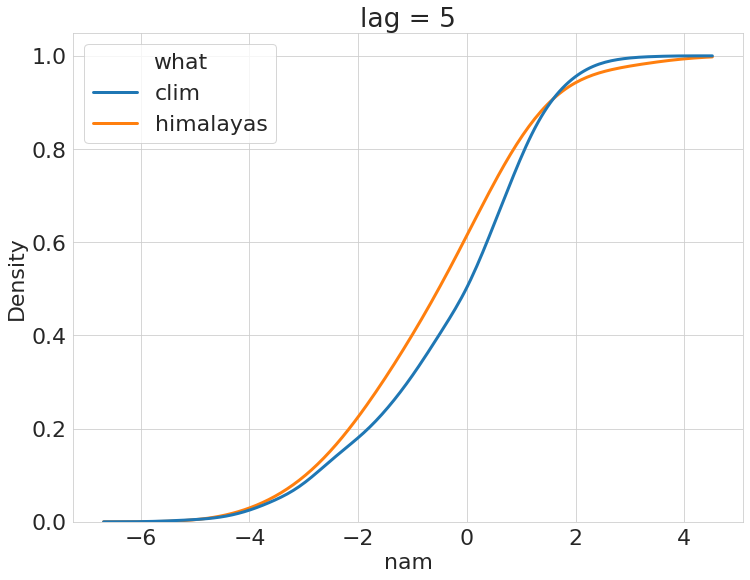

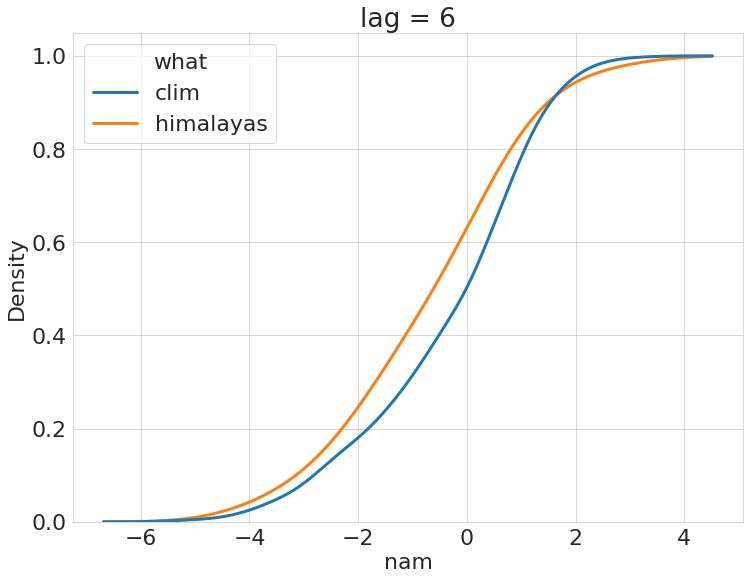

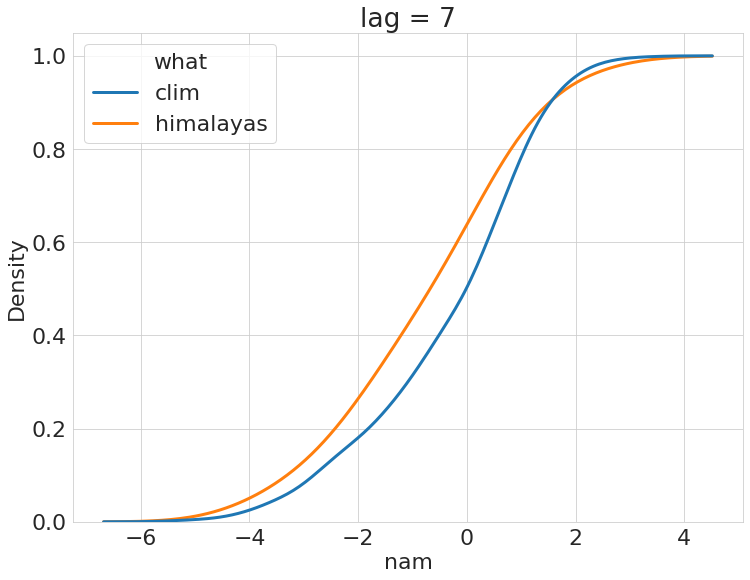

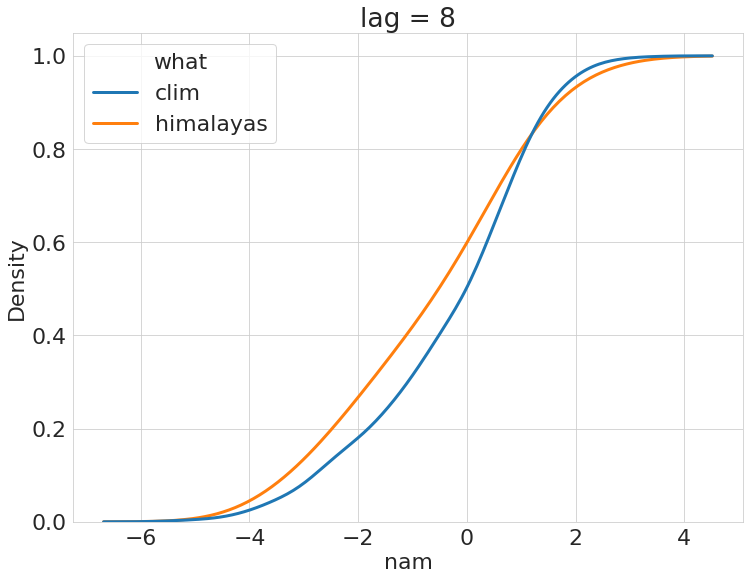

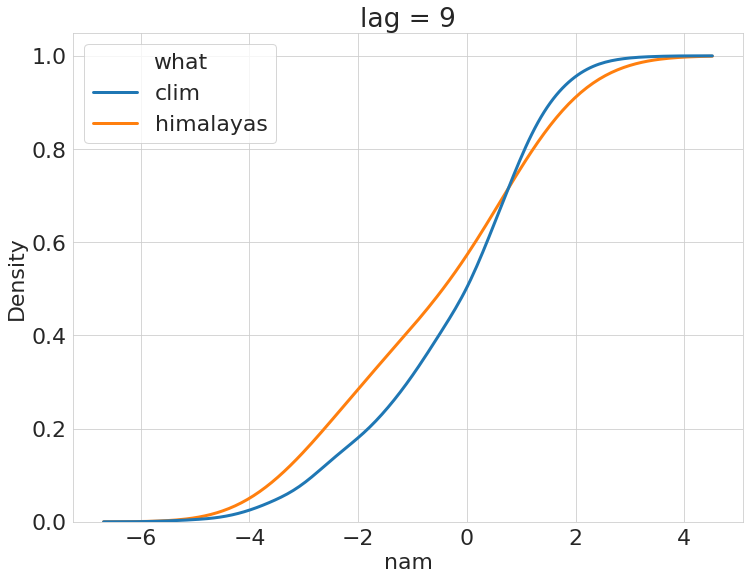

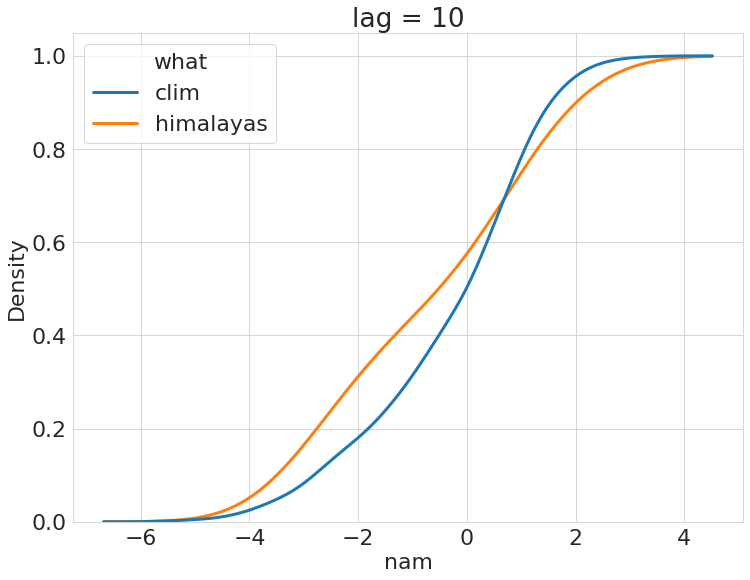

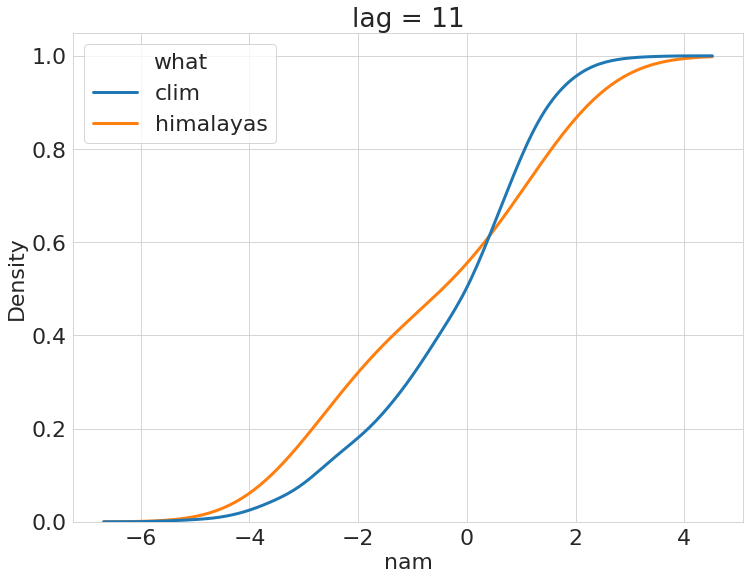

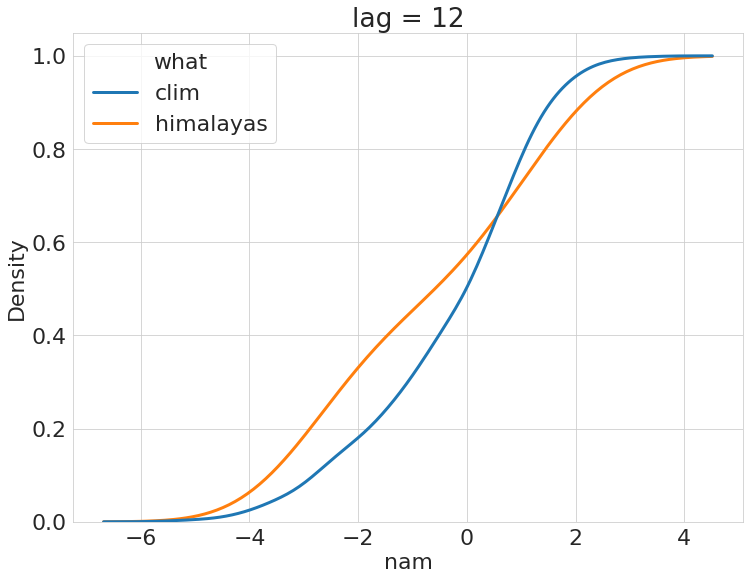

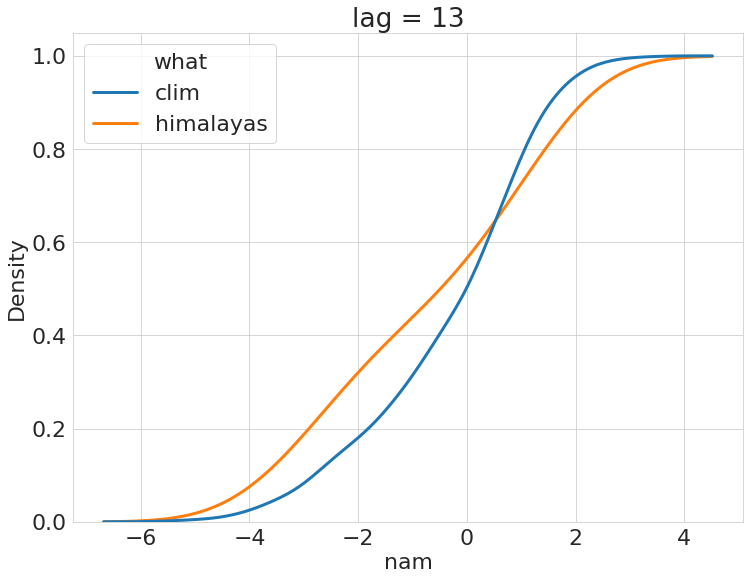

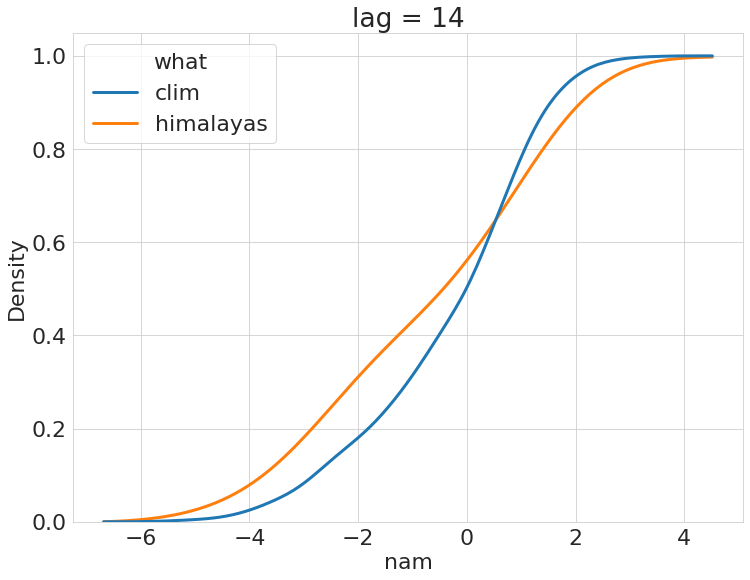

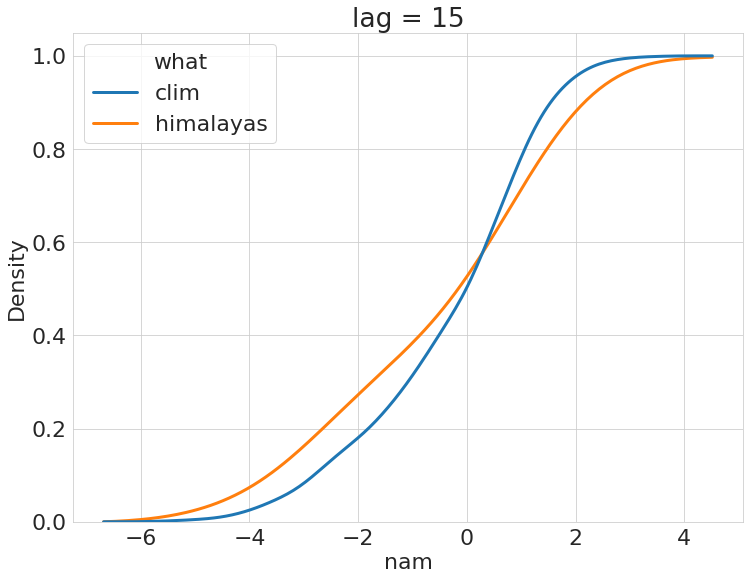

In [145]:
thres = -1
sel_plev = 10
#lag_r  = range(-15,16)
sel_var = 'nam'
sel_what = 'himalayas'

prob_ls = []
prob_clim_ls = []
for sel_lag in lag_r:
    #print(sel_lag)
    month_mask =  (ds_am.time.dt.month == 12) | \
        (ds_am.time.dt.month == 1) | (ds_am.time.dt.month == 2) #| (ds.time.dt.month == 3)

    df_clim = ds_am.sel(time = month_mask, \
                        plev = [1000,100,50,10]).to_array().to_dataframe(name = sel_var).reset_index().drop(columns=['time','variable'])
    df_clim['what'] = ['clim']*df_clim.shape[0]
    df_clim['lag'] = [sel_lag]*df_clim.shape[0]
    #df_clim['lag'] = [0]*df_clim.shape[0]
    df_merged = pd.concat([df_clim, df_all])
    
    mask = df_merged['what'].isin([sel_what,'clim']) & \
    (df_merged['plev'] == sel_plev) & (df_merged['lag'] == sel_lag)
    data = df_merged[mask]
    fig = plt.figure(figsize=(12,9)) # palette="crest",
    p = sns.kdeplot(
    data=data, x="nam", hue="what", lw = 3,
    cumulative=True, common_norm=False, common_grid=True,
    )
    plt.title(f'lag = {sel_lag}')
    #sys.exit()
    
    
    for i, name in zip(range(2), [sel_what, 'clim']):
        x,y=p.get_lines()[i].get_data()    
        prob = y[x<=thres][-1]      
        if name == sel_what:
            prob_ls.append(prob)
        elif name == 'clim':
            prob_clim_ls.append(prob)
            
        print(sel_lag, thres, name, prob)
       
    

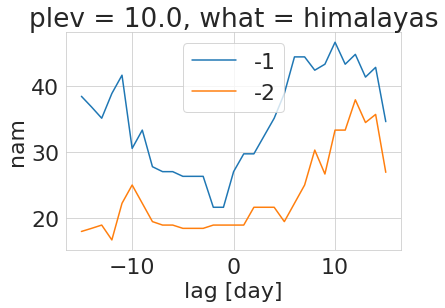

In [136]:
sel_dict = dict(plev = 10, what = 'himalayas')
arr = ds_all['nam'].sel(**sel_dict)
mask_total = arr < np.inf
#arr.where(mask, drop = True).sum('time').plot()
thres = -1
mask = arr <= thres
(mask.sum('time')/mask_total.sum('time')*100).plot(label = f'{thres}')
thres = -2
mask = arr <= thres
(mask.sum('time')/mask_total.sum('time')*100).plot(label = f'{thres}')
plt.legend()

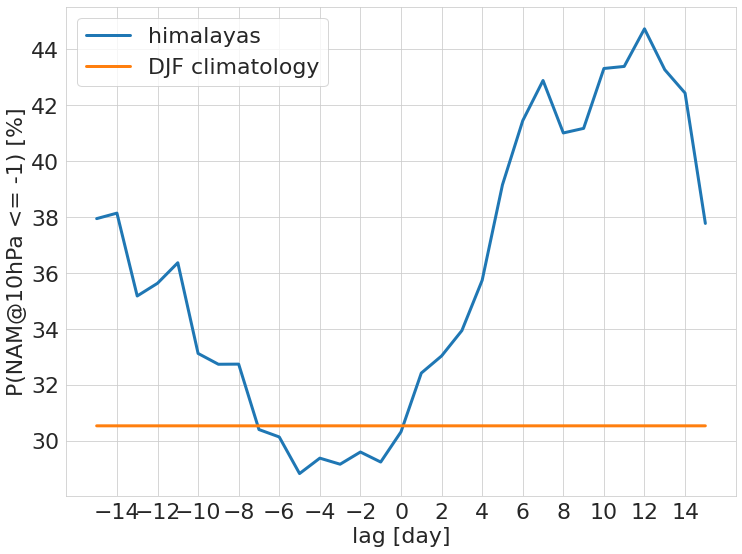

In [260]:
fig = plt.figure(figsize=(12,9)) # palette="crest",

plt.plot(lag_r, np.array(prob_ls)*100, lw = 3, label = sel_what)
plt.plot(lag_r, np.array(prob_clim_ls)*100, lw = 3, label = 'DJF climatology')
plt.xlabel('lag [day]')
plt.ylabel(f'P(NAM@{sel_plev}hPa <= {thres}) [%]')
plt.xticks(lag_r[1::2])
plt.legend()

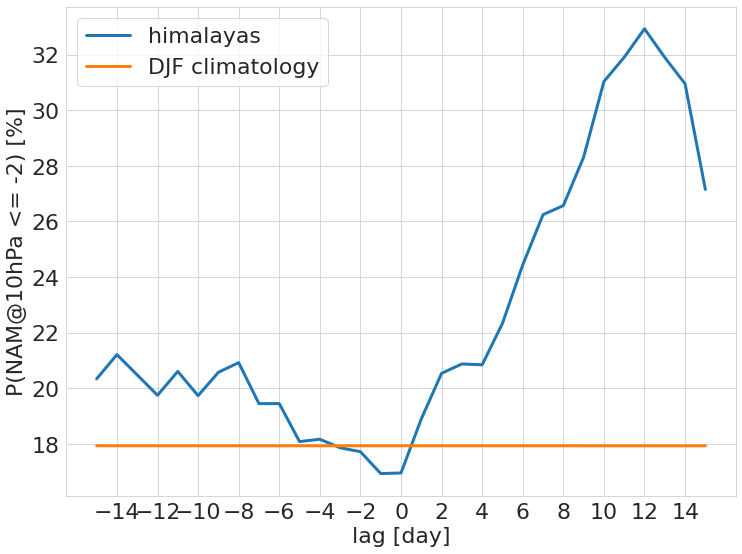

In [258]:
fig = plt.figure(figsize=(12,9)) # palette="crest",

plt.plot(lag_r, np.array(prob_ls)*100, lw = 3, label = sel_what)
plt.plot(lag_r, np.array(prob_clim_ls)*100, lw = 3, label = 'DJF climatology')
plt.xlabel('lag [day]')
plt.ylabel(f'P(NAM@{sel_plev}hPa <= {thres}) [%]')
plt.xticks(lag_r[1::2])
plt.legend()

### Final

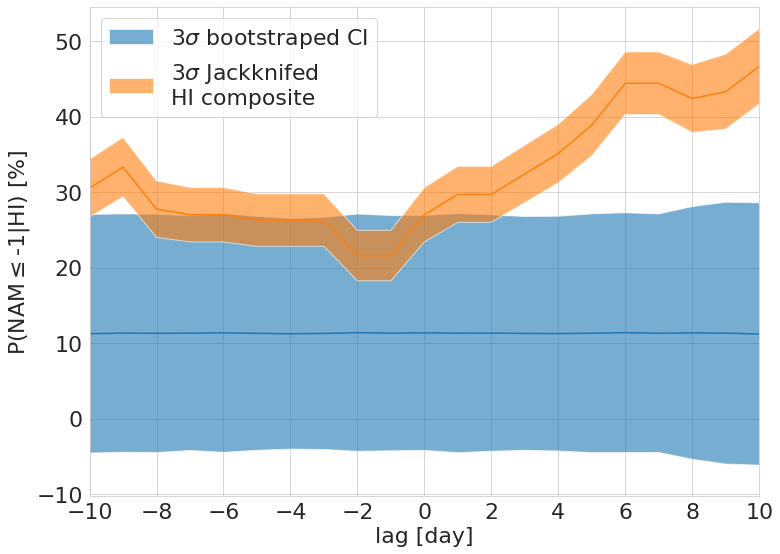

In [150]:
sel_plev = 10
sel_dict = dict(plev = sel_plev, what = 'himalayas')
ns = 3

thres = -1

fig = plt.figure(figsize = (12,9))
arr = ds_all_r['nam'].sel(**sel_dict)#ds_all['nam'].sel(**sel_dict)
mask_total = arr < np.inf
#arr.where(mask, drop = True).sum('time').plot()

mask = arr <= thres
temp = (mask.sum('sample')/mask_total.sum('sample')*100)
s = ns*temp.std('iteration')
m = temp.mean('iteration')
#std.plot(label = f'{thres}')
plt.fill_between(lag_r, m+s,m-s, alpha = 0.6, label = r'$3\sigma$ bootstraped CI')
plt.plot(lag_r, m)

arr = ds_all['nam'].sel(**sel_dict)
ds_ls = []
for lag in arr.lag:
    temp = arr.sel(lag = lag).dropna('time')
    mask_total = temp < np.inf
    
    drop_ls = []
    for di in temp.time:
        mask = temp.drop_sel(time = di.values) <= thres
        prob = (mask.sum('time')/mask_total.sum('time')*100)
        
        drop_ls.append(prob)
        
    ds_ls.append(xr.concat(drop_ls, dim = 'its').std('its'))
    

prob_std = ns*xr.concat(ds_ls, dim = 'lag')

        
        
        
mask_total = arr < np.inf
#arr.where(mask, drop = True).sum('time').plot()
mask = arr <= thres
prob_mean = (mask.sum('time')/mask_total.sum('time')*100)
#prob_mean.plot(lw =5, label = 'HI composite')
plt.fill_between(lag_r, prob_mean+prob_std,prob_mean-prob_std, alpha = 0.6, 
                 label = r'$3\sigma$'+' Jackknifed\nHI composite')
plt.plot(lag_r, prob_mean)


plt.ylabel(f'P(NAM'+r"$\leq$"+f'{thres}|HI) [%]')
plt.xlabel('lag [day]')
#plt.title(f'at {sel_plev}hPa')
plt.legend()
plt.xlim(-10,10)
plt.xticks(np.arange(-10,12,2))
plt.savefig(f'NAM_lagA_probability_{sel_plev}hPa_CI.pdf', bbox_inches='tight')